In [37]:
import sys
sys.path.append("..")

%load_ext autoreload
%autoreload 1
%aimport pygenesig.validation
%aimport pygenesig.gini
%aimport pygenesig.bioqc
%aimport pygenesig.perfmeasures
%aimport pygenesig.mcp_counter
%aimport pygenesig.tools
%matplotlib inline

from pygenesig.validation import * 
from pygenesig.gini import * 
from pygenesig.bioqc import * 
from pygenesig.mcp_counter import * 
from pygenesig.tools import * 
import pygenesig.perfmeasures as pm
import numpy as np
import pandas as pd

import seaborn as sns
from pylab import * 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Signature Generation and Validation on GTEx with gini-index. 
In this document, we generate and test the signatures ** on the same dataset **. The final result might therefore not be representative. This document is to demonstrate the ease-of-use of *pygenesig*. 

## Load a dataset
Expression Matrix + Tissue Labels

In [9]:
expr = np.load("../../data/gtex/exprs.npy")
target = np.genfromtxt("../../data/gtex/target.csv", delimiter=",", dtype=str)

## Make Signatures

In [10]:
max_rk = 5
min_gini = .85

In [11]:
sg = MCPSignatureGenerator(expr, target)

In [12]:
signatures = sg.mk_signatures()

/pstore/home/sturmg/projects/gene-set-study/pygenesig/mcp_counter.py:45: RuntimeWarning: invalid value encountered in true_divide
  np.subtract(x_max, x_min)
/pstore/home/sturmg/projects/gene-set-study/pygenesig/mcp_counter.py:45: RuntimeWarning: divide by zero encountered in true_divide
  np.subtract(x_max, x_min)


### store signatures as GMT
first, translate to gene symbols

In [43]:
gene_symbols

array(['DDX11L1', 'WASH7P', 'MIR1302-11', ..., 'MT-TE', 'MT-CYB', 'MT-TT'], 
      dtype='<U22')

In [15]:
gene_symbols = np.genfromtxt("../../data/gtex/gene_symbols.csv", delimiter=",", dtype=str)
gene_symbols = gene_symbols[:, 1]

In [16]:
gene_signatures = {
    tissue: set([gene_symbols[i] for i in genes]) for tissue, genes in signatures.items()
}

In [17]:
write_gmt(gene_signatures, "../../results/gtex_mcp.gmt".format(min_gini, max_rk),
          description="Derived from GTEx dataset with pygenesig. MCP counter method. ".format(min_gini, max_rk))

In [84]:
gene_signatures = load_gmt("../../results/gtex_mcp.gmt")

In [85]:
signatures = {
    tissue: np.where(np.in1d(gene_symbols, genes))[0].tolist() for tissue, genes in gene_signatures.items()
}

In [86]:
signatures

{'Adipose Tissue': [16356, 22523, 32248, 32250],
 'Adrenal Gland': [242,
  357,
  405,
  501,
  575,
  609,
  638,
  742,
  769,
  788,
  845,
  932,
  976,
  978,
  1167,
  1391,
  1392,
  1400,
  1495,
  1527,
  1573,
  1660,
  1662,
  1663,
  1664,
  1826,
  2063,
  2095,
  2137,
  2230,
  2345,
  2544,
  2546,
  2554,
  2683,
  2689,
  2690,
  2691,
  3017,
  3208,
  3306,
  3361,
  3546,
  3685,
  3787,
  3823,
  3832,
  3851,
  3926,
  4265,
  4266,
  4420,
  4561,
  4563,
  4602,
  4607,
  4664,
  4699,
  4720,
  4738,
  4739,
  4867,
  4877,
  4988,
  5140,
  5263,
  5264,
  5302,
  5377,
  5391,
  5489,
  5559,
  5663,
  5693,
  5707,
  5720,
  5722,
  5723,
  5861,
  5868,
  5885,
  5930,
  5968,
  6003,
  6004,
  6005,
  6006,
  6007,
  6086,
  6141,
  6214,
  6272,
  6354,
  6361,
  6362,
  6392,
  6505,
  6513,
  6690,
  6699,
  6903,
  6923,
  6998,
  7221,
  7278,
  7282,
  7291,
  7337,
  7369,
  7444,
  7602,
  7715,
  7811,
  7812,
  7888,
  7914,
  7939,
  7999,
  80

In [87]:
for name, genes in signatures.items():
    print(name, len(genes))

Thyroid 240
Blood Vessel 101
Stomach 1
Small Intestine 115
Ovary 875
Heart 111
Adrenal Gland 715
Vagina 1
Prostate 76
Salivary Gland 58
Brain 585
Esophagus 2
Pituitary 999
Lung 94
Pancreas 176
Adipose Tissue 4
Skin 14
Blood 128
Breast 1
Uterus 67
Liver 643
Muscle 1202
Spleen 561
Nerve 178
Testis 8268
Kidney 959
Colon 1


## Test Signatures
(You could also load a different dataset, e.g. from a different species here)

In [88]:
st = MCPSignatureTester(expr, target)

In [89]:
actual, predicted = st.test_signatures(signatures)

In [90]:
confmat = st.confusion_matrix(signatures, actual, predicted)

In [91]:
sig_labels = st.sort_signatures(signatures)

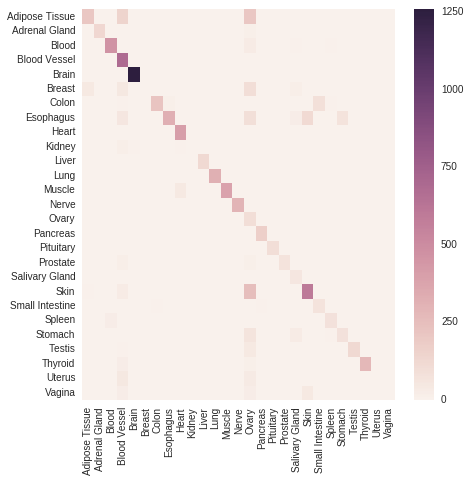

In [92]:
fig, ax = subplots(figsize=(7, 7))
sns.heatmap(confmat, ax=ax, xticklabels=sig_labels, yticklabels=sig_labels)


Binary classifications performance per signatures

In [83]:
print("Tissue", "Sens", "Spec", "MCC")
for i, sig in enumerate(sig_labels):
    TP = confmat[i, i]
    FN = np.sum(confmat[i, :]) - TP
    FP = np.sum(confmat[:, i]) - TP
    TN = np.sum(confmat) - TP - FN - FP
    m = (TP, FN, FP, TN)
    print(sig, pm.sens(*m), pm.spec(*m), pm.mcc(*m))

Tissue Sens Spec MCC
Adipose Tissue 0.974003466205 0.927277302466 0.667986086731
Adrenal Gland 0.993103448276 0.991885441527 0.81797469407
Blood 0.0 0.999750436736 0.00386816093502
Blood Vessel 0.78084179971 0.913348647269 0.570459585394
Brain 0.0587768069897 1.0 0.224800172795
Breast 0.364485981308 0.988208398508 0.40451267928
Colon 0.710144927536 0.882151589242 0.373150699784
Esophagus 0.908163265306 0.844750605945 0.516680812681
Heart 0.388349514563 0.999753482066 0.610077646981
Kidney 0.65625 0.997998351584 0.601854921382
Liver 0.90756302521 0.959909588389 0.461458982308
Lung 0.996875 0.945033516149 0.624805886128
Muscle 0.00697674418605 1.0 0.0814074331353
Nerve 0.0 0.997445566233 0.00955591964868
Ovary 0.0412371134021 1.0 0.201958022387
Pancreas 1.0 0.977615513526 0.68334588609
Pituitary 0.0 1.0 nan
Prostate 0.735849056604 0.981589262383 0.494206434901
Salivary Gland 0.40350877193 0.982994803968 0.239215441626
Skin 0.0191011235955 0.972495088409 0.0865244117514
Small Intestine 0.

/pstore/home/sturmg/projects/gene-set-study/pygenesig/perfmeasures.py:23: RuntimeWarning: invalid value encountered in true_divide
  return np.divide(TP * TN + FP * FN, sqrt((TP+FP) * (TP+FN) * (TN+FP) * (TN+FN)))
